# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">Rubén Vera Martínez</font>

E-mail: <font color="blue">ruben.vera01@estudiant.upf.edu</font>

Date: <font color="blue">04/11/2022</font>

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [3]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"


In [4]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


In [5]:
def yearof(title):
    #Split title to get the age which is between parenthesis and then return it.
    split = title.split("(")
    resplit = split[len(split)-1].split(")")
    year = int(resplit[0])
    return year

    
movies['year'] = movies.apply(lambda x: yearof(x['title']), axis = 1)
display(movies.head(5))

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


Both ratings_raw and users have the same column "user_id" so you can join them on this field.
Both ratings_raw and movies have the same column "movie_id" so you can join them on this field.


In [6]:
#Merge both dataframes as it is said.
ratings = pd.merge(ratings_raw, movies, how = 'inner', on = 'movie_id')
display(ratings.head(5))

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,152,3624,3.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
2,171,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
3,276,3624,4.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
4,494,3624,3.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000


In [7]:
def find_movies(text, movies):
    #For all the movies we look , 
    for i in range(len(movies)):
        #if the title have the input text
        if text in movies["title"][i]:
            #if it has we print title and movie id
            print("movie_id: ", movies["movie_id"][i], ", title: ", movies["title"][i])
find_movies("Barcelona", movies) 

movie_id:  60950 , title:  Vicky Cristina Barcelona (2008)
movie_id:  182911 , title:  Barcelona Christmas Night (2015)


# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

In [8]:
# Leave this code as-is
ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

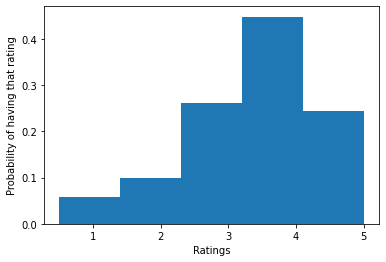

In [9]:
x = ratings['rating'] 
#Plot the histogram with density = True to see probabilities and not the count, 5 bins because we have 5 ratings.
plt.hist(x, bins = 5, density = True, align = 'mid')
plt.xlabel("Ratings")
plt.ylabel("Probability of having that rating")
plt.show()

Majority of people rates with a 3 or 4 the movies.
There are few people who rates below 3 because it's to low rate and on the other hand, people don't rate with a 5 because this means movie is perfect and it's hard to say that from any movie.
So, I'd say that in general if a movie is good, people with rate with a 4 or 5.
And if it's bad, people with rate with a 3 or lower.

In [10]:
good_ratings = ratings[ratings.rating > 4] #We take films with rating > 4
good_ratings = good_ratings.sort_values('rating', ascending = False) #Sort them descending to see the films with highest rating
display(good_ratings.head(10))

bad_ratings = ratings[ratings.rating < 2] #We take films with rating < 2
bad_ratings = bad_ratings.sort_values('rating', ascending = True) #Sort them ascending to see the films with least rating
display(bad_ratings.head(10))

,user_id,movie_id,rating,title,genres,year
13,3050,3624,5.0,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
129963,142226,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129945,141470,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129948,141675,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129949,141701,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129950,141705,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
334130,145457,8958,5.0,Ray (2004),Drama,2004
129952,141794,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129953,141831,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004
129954,141863,7361,5.0,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,2004


,user_id,movie_id,rating,title,genres,year
305982,103590,6535,0.5,"Legally Blonde 2: Red, White & Blonde (2003)",Comedy,2003
179078,136045,7254,0.5,The Butterfly Effect (2004),Drama|Sci-Fi|Thriller,2004
414998,74608,3991,0.5,102 Dalmatians (2000),Children|Comedy,2000
355902,6711,3273,0.5,Scream 3 (2000),Comedy|Horror|Mystery|Thriller,2000
261435,2287,4728,0.5,Rat Race (2001),Comedy,2001
179255,152546,7254,0.5,The Butterfly Effect (2004),Drama|Sci-Fi|Thriller,2004
179365,284,8368,0.5,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,2004
261424,160890,4701,0.5,Rush Hour 2 (2001),Action|Comedy,2001
179389,2005,8368,0.5,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,2004
414962,41234,3991,0.5,102 Dalmatians (2000),Children|Comedy,2000


The film "Eternal Sunshine of the Spotless Mind" is in general rated with a 5 so, with a high level of confidence you can say that this movie is good.
Otherwise, 2 people out of 10 rated "Harry Potter and the Prisoner of Azkaban" with a 0.5, so this movie will be probably bad.
So, the more people rates good or bad a film, the more sure you can be that this film is good or bad.

## 2.2. Genres distribution

In [14]:
movie_genres =[]
genres_list = []
for i in range(len(movies)):
    #First, we split the genres of movies which have 2 or more genres.
    genres = movies['genres'][i].split('|')
    #Then if we didn't add the genre yet, we add genre to the list.
    for genre in genres:
        if genre not in movie_genres:
            movie_genres.append(genre)
display(movie_genres)

['Crime',
 'Drama',
 'Comedy',
 'Adventure',
 'Sci-Fi',
 'Thriller',
 'Romance',
 'Horror',
 'Mystery',
 'Action',
 'Animation',
 'Children',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Fantasy',
 'IMAX',
 'Film-Noir',
 '(no genres listed)']

In [15]:
def frequency(dataset):
    movie_genres =[]
    list_to_check = []
    keyword_occurences = []
    #Firstly, add all genres as single to the movie_genres list
    for i in range(len(dataset)):
        genres = dataset['genres'][i].split('|')
        for genre in genres:
            movie_genres.append(genre)
    #Once we have them splitted, we count them and add them to the list we will return
    for genre in movie_genres:
        if genre not in list_to_check:
            list_to_check.append(genre)
            keyword_occurences.append([genre, movie_genres.count(genre)])
    #Finally, we return the list sorted by the count of each genre with sorted()
    return sorted(keyword_occurences, key = lambda x: x[1], reverse = True) 


In [17]:
display(frequency(movies))

[['Drama', 13666],
 ['Comedy', 8898],
 ['Thriller', 5437],
 ['Documentary', 4473],
 ['Action', 3901],
 ['Romance', 3846],
 ['Horror', 3431],
 ['Crime', 2425],
 ['(no genres listed)', 2200],
 ['Sci-Fi', 1907],
 ['Adventure', 1906],
 ['Children', 1639],
 ['Animation', 1553],
 ['Mystery', 1516],
 ['Fantasy', 1456],
 ['War', 679],
 ['Musical', 308],
 ['Western', 194],
 ['IMAX', 173],
 ['Film-Noir', 21]]

In [236]:
# Change the colors/style if you want
def wordcloud(keyword_occurences):
    # Generate the word cloud
    genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
    genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

    # Plot the word cloud
    f, ax = plt.subplots(figsize=(16, 8))
    plt.imshow(genre_wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

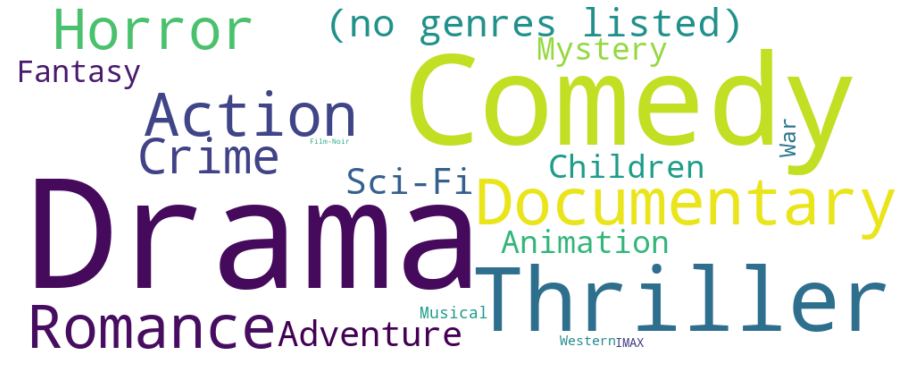

In [237]:
wordcloud(frequency(movies))

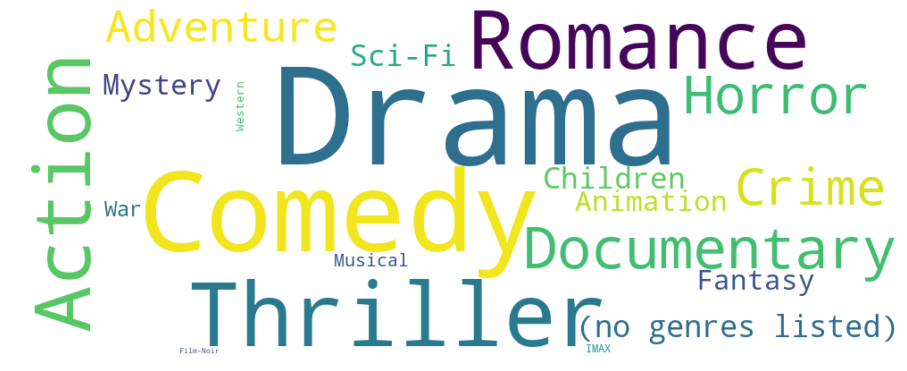

In [238]:
#Split movies by movies before 2010.
pre_2010 = movies[movies.year < 2010]
pre_2010 = pre_2010.reset_index() #Reset_index to avoid missmatching
keyword_occurences_pre_2010 = frequency(pre_2010)#Calculate frequency of genres
wordcloud(keyword_occurences_pre_2010)#Generate the wordcloud

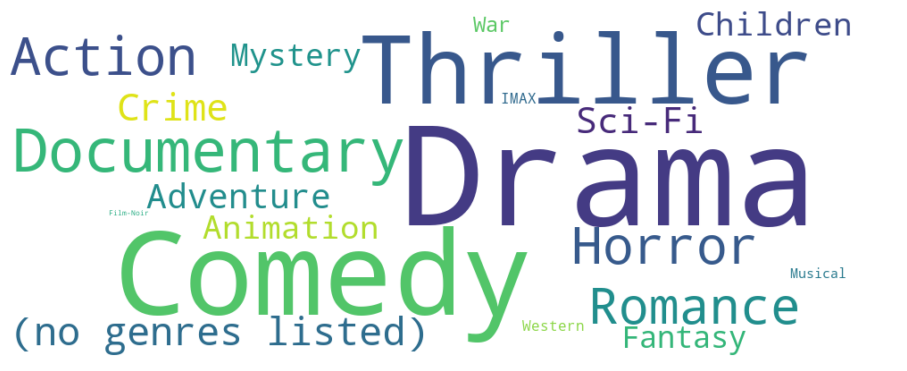

In [239]:
#Split movies by movies after 2010
post_2010 = movies[movies.year >= 2010]
post_2010 = post_2010.reset_index() #Reset_index to avoid missmatching
keyword_occurences_post_2010 = frequency(post_2010) #Calculate frequency of genres
wordcloud(keyword_occurences_post_2010)#Generate the wordcloud

With this two wordclouds we can see how genres of films changed before 2010 and post 2010 probably because what people demanded.
Before 2010, Romance's films were highly produced, while post 2010, this films were less produced.
Thriller, Drama and Comedy genres are as produced before 2010 as post 2010.
Action movies also lost a bit popularity post 2010.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

In [243]:
genres_list = []
#We save all genres but this time, as they are, not as a single genre
for i in range(len(movies)):
    genres = movies['genres'][i].split('|')
    genres_list.append(genres)
#Add the column genres_arr with the genres_list as values.
movies['genres_arr'] = genres_list    
#We convert it to string, which will be useful later.
movies['genres_arr'].fillna('').astype('str')
display(movies.head(5))

0                         ['Crime', 'Drama']
1                                 ['Comedy']
2        ['Adventure', 'Sci-Fi', 'Thriller']
3                      ['Comedy', 'Romance']
4                                 ['Comedy']
                        ...                 
33163        ['Action', 'Comedy', 'Romance']
33164                              ['Drama']
33165                        ['Documentary']
33166                    ['Comedy', 'Drama']
33167                 ['(no genres listed)']
Name: genres_arr, Length: 33168, dtype: object

In [245]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][2], movies['genres_arr'][2]))

Transformed: Adventure|Sci-Fi|Thriller → ['Adventure', 'Sci-Fi', 'Thriller']


In [246]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,[(no genres listed)]
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"[Action, Adventure, Fantasy]"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,[(no genres listed)]
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"[Action, Adventure, Sci-Fi]"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"[Action, Adventure, Comedy, Sci-Fi]"


In [247]:
#We prepare the vectorizer with ngram_range = 1,2 and setup language to english
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = {'english'})
#We apply the Tfidf vectorizer to the dataset created previously
tfidf_matrix = vectorizer.fit_transform(movies_filtered['genres'])

In [248]:
tfidf_matrix.shape

(7890, 130)

## 3.2. Calculate most similar movies

In [249]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [250]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

0.178 159441 The Do-Over (2016)
0.000 159445 Nise: The Heart of Madness (2016)
0.000 159447 Before I Wake (2016)
0.000 159451 Graduation (2016)
0.178 159482 The Bandit Hound (2016)
0.238 159484 Life on the Line (2016)
0.000 159606 Kapoor and Sons (2016)
0.348 159626 Zoombies (2016)
0.000 159638 Nothing Left Unsaid: Gloria Vanderbilt & Anderson Cooper (2016)
0.000 159652 Chicken (2016)
0.000 159666 Poor Boy (2016)
0.720 159690 Teenage Mutant Ninja Turtles: Out of the Shadows (2016)
0.000 159696 The Darkness (2016)
0.000 159717 The Fundamentals of Caring (2016)
0.000 159721 Brexit: The Movie (2016)
0.178 159735 Sin Filtro (2016)
0.178 159755 Popstar: Never Stop Never Stopping (2016)
0.000 159779 A Midsummer Night's Dream (2016)
0.000 159784 United States of Love (2016)
0.000 159799 Dark Signal (2016)
0.000 159827 All the Way (2016)
0.178 159849 Bo Burnham: Make Happy (2016)
0.000 159858 The Conjuring 2 (2016)
0.000 159917 Weiner (2016)
0.119 159970 Never Back Down: No Surrender (2016)
0.

0.079 163615 Citizen Soldier (2016)
0.000 163639 DC Super Hero Girls: Hero of the Year (2016)
0.000 163643 Resurrection (2016)
0.000 163645 Hacksaw Ridge (2016)
0.000 163649 Fairlane Road (2016)
0.178 163653 David Cross: Making America Great Again (2016)
0.000 163663 Other People (2016)
0.000 163681 Mostly Ghostly 3: One Night in Doom House (2016)
0.000 163691 City 40 (2016)
0.000 163701 Siccin 3: CÃ¼rmÃ¼ Ask (2016)
0.080 163715 Rampage: President Down (2016)
0.000 163771 For the Love of Spock (2016)
0.000 163773 Los Punks: We Are All We Have (2016)
0.108 163775 Toro (2016)
0.066 163779 Kiki, Love to Love (2016)
0.087 163783 Summer of 8 (2016)
0.087 163807 The Most Beautiful Day (2016)
0.000 163909 Divines (2016)
0.076 163911 USS Indianapolis: Men of Courage (2016)
0.000 163913 Devil's Bride (2016)
0.000 163917 SÃ£o Jorge (2016)
0.000 163921 Wolf Creek (2016)
0.178 163923 Jules and Dolores (2016)
0.000 163931 Billy Lynn's Long Halftime Walk (2016)
0.000 163935 Born in Heinola (2016)
0.

0.051 165867 Pure Pwnage: Teh Movie (2016)
0.000 165869 Heartstone (2016)
0.000 165877 The Dark Stranger (2016)
0.000 165879 The Evil in Us (2016)
0.000 165883 May God Save Us (2016)
0.108 165885 Smoke & Mirrors (2016)
0.000 165889 Acantilado (2016)
0.000 165891 The Possession Experiment (2016)
0.178 165893 The Jews (2016)
0.087 165895 Spaceman (2016)
0.178 165897 Army of One (2016)
0.066 165901 Happy Bhag Jayegi (2016)
0.000 165925 The Congressman (2016)
0.118 165931 Ivan Tsarevich & the Grey Wolf 3 (2016)
0.000 165933 The Ivory Game (2016)
0.000 165937 Collateral Beauty (2016)
0.087 165939 First Girl I Loved (2016)
0.179 165947 The True Memoirs of an International Assassin (2016)
0.000 165949 You Will Know What to Do With Me (2016)
0.087 165951 Saint Amour (2016)
0.000 165969 HyperNormalisation (2016)
0.042 166005 La folle histoire de Max et LÃ©on (2016)
0.000 166009 The Chronicles of Melanie (2016)
0.000 166011 Shangri-La Suite (2016)
0.572 166013 Scrat: Spaced Out (2016)
0.087 1660

0.000 169190 Teenage Kicks (2016)
0.000 169194 Cam-Girl (2016)
0.057 169198 Almost Adults (2017)
0.178 169204 Mein Blind Date mit dem Leben (2017)
0.000 169210 A Good Wife (2017)
0.000 169216 Spoor (2017)
0.000 169218 God's Own Country (2017)
0.000 169220 A Fantastic Woman (2017)
0.000 169222 Colo (2017)
0.000 169224 Deadly Daughters (2016)
0.000 169242 Ana, mon amour (2017)
0.000 169244 Hostages (2017)
0.238 169248 Kill Ratio (2016)
0.040 169250 Trash Fire (2016)
0.000 169256 Lovesong (2017)
0.178 169264 Jen Kirkman: Just Keep Livinâ? (2017)
0.178 169266 Colin Quinn: The New York Story (2016)
0.178 169268 Cedric the Entertainer: Live from the Ville (2016)
0.178 169274 The Fabulous Pastars (2016)
0.178 169280 The Fourth Annual 'On Cinema' Oscar Special (2016)
0.549 169288 Major Grom (2017)
0.000 169294 Becoming Warren Buffett (2017)
0.000 169298 Drifter (2016)
0.178 169302 Everybody Loves Somebody (2017)
0.000 169304 The Reconquest (2016)
0.000 169306 Max Rose (2016)
0.178 169308 Mat

0.000 171485 The Earthquake (2016)
0.108 171491 Unlocked (2017)
0.000 171497 Voice from the Stone (2017)
0.044 171501 Small Crimes (2017)
0.000 171505 On the Milky Road (2016)
0.000 171509 Kappen! (2016)
0.178 171517 Kolonya Cumhuriyeti (2017)
0.000 171537 Command and Control (2016)
0.066 171555 Classmates (2016)
0.178 171559 Superbad (2016)
0.238 171579 Rising Fear (2016)
0.000 171581 Flower (2017)
0.000 171583 Super Dark Times (2017)
0.178 171589 A Few Less Men (2016)
0.000 171597 Karl Marx City (2016)
0.000 171599 Bottom of the World (2017)
0.108 171601 Stratton (2017)
0.166 171605 The Ornithologist (2016)
0.000 171607 Bad Girl (2016)
0.178 171609 The Lovers (2017)
0.308 171611 Baahubali 2: The Conclusion (2017)
0.000 171623 Tomato Red (2017)
0.492 171625 Taking Earth (2017)
0.000 171629 Pet Fooled (2016)
0.178 171661 Omicidio all'italiana (2017)
0.000 171689 Norman: The Moderate Rise and Tragic Fall of a New York Fixer (2017)
0.000 171701 The Death of Louis XIV (2016)
0.000 171715 

0.000 175621 Tonight She Comes (2016)
0.359 175623 Drone Wars (2016)
0.119 175625 The Dragon Spell (2016)
0.000 175629 Before the Streets (2016)
0.179 175637 First Round Down (2017)
0.352 175643 Zygote (2017)
0.000 175647 24Ã36 (2016)
0.000 175649 Wish Upon (2017)
0.178 175655 Girls Trip (2017)
0.178 175657 Landline (2017)
0.000 175659 Detroit (2017)
0.179 175661 The Hitman's Bodyguard (2017)
0.000 175663 77 Minutes (2016)
0.000 175665 The Only Living Boy in New York (2017)
0.000 175667 Columbus (2017)
0.000 175669 Tulip Fever (2017)
0.238 175671 Birth of the Dragon (2017)
0.000 175673 The Life and Death of John Gotti (2017)
0.000 175687 Blood Hunters (2016)
0.058 175693 Rick and Morty: State of Georgia Vs. Denver Fenton Allen (2016)
0.000 175699 Fittest On Earth: A Decade Of Fitness (2017)
0.000 175701 Zero 3 (2017)
0.000 175707 A German Life (2016)
0.087 175719 Adios amigos (2016)
0.000 175723 Feed (2017)
0.000 175741 The Girl from the Song (2017)
0.178 175743 Self-criticism of a Bo

0.000 178447 Cult of Chucky (2017)
0.000 178453 Ukraine on Fire (2016)
0.000 178455 Under the Turban (2016)
0.000 178465 Clowntergeist (2016)
0.000 178473 The Settlers (2016)
0.000 178477 On the Beach at Night Alone (2017)
0.090 178489 Baar Baar Dekho (2016)
0.000 178501 House of Others (2016)
0.000 178509 Our Souls at Night (2017)
0.093 178517 Sniper: Ultimate Kill (2017)
0.000 178521 The Babysitter (2017)
0.000 178523 1922 (2017)
0.238 178527 Nitro Rush (2016)
0.178 178573 The Reunion 3: Baptism (2016)
0.087 178605 Tiger Theory (2016)
0.057 178615 Front Cover (2016)
0.000 178617 ÐÐ°Ð¿Ð°ÑÐ½Ð¸Ðº (2017)
0.064 178637 Date of the Dead (2017)
0.238 178639 Wolf Warrior 2 (2017)
0.000 178641 Chasing the Dragon (2017)
0.000 178645 Diana: In Her Own Words (2017)
0.000 178647 Girls in the Dark (2017)
0.066 178649 Wedding Unplanned (2017)
0.419 178651 Empire of the Sharks (2017)
0.000 178663 Restless Creature: Wendy Whelan (2017)
0.178 178665 ÐÐ°Ð±ÑÑÐºÐ° Ð»ÑÐ³ÐºÐ¾Ð³Ð¾ Ð¿Ð¾Ð²ÐµÐ´ÐµÐ½Ð¸Ñ (2

0.000 181073 Mariah Carey's All I Want for Christmas Is You (2017)
0.000 181075 The Man Who Invented Christmas (2017)
0.087 181077 Almost Friends (2017)
0.087 181079 Tumhari Sulu (2017)
0.000 181105 Black Water (2017)
0.108 181111 Theeran Adhigaram Ondru (2017)
0.000 181115 Hangman (2017)
0.117 181119 Nick Off Duty (2016)
0.178 181135 A Bad Idea Gone Wrong (2017)
0.178 181137 Rodney Carrington: Here Comes The Truth (2017)
0.178 181139 Lynne Koplitz: Hormonal Beast (2017)
0.000 181141 Trophy (2017)
0.000 181155 Gilbert (2017)
0.000 181157 Paradise (2016)
0.000 181171 Versus: The Life and Films of Ken Loach (2016)
0.000 181203 200 Degrees (2017)
0.088 181205 Control (2017)
0.178 181209 Judah Friedlander: America Is the Greatest Country in the United States (2017)
0.000 181211 Vaxxed: From Cover-Up to Catastrophe (2016)
0.000 181215 The Hatred (2017)
0.325 181217 Doctor Who: The Return Of Doctor Mysterio (2016)
0.000 181227 The Grown-Ups (2016)
0.000 181229 Bad Blood: The Movie (2017)
0.1

0.000 183423 AlphaGo (2017)
0.310 183437 World of Tomorrow Episode Two: The Burden of Other People's Thoughts (2017)
0.087 183441 Ä°ftarlÄ±k Gazoz (2016)
0.061 183445 Aile ArasÄ±nda (2017)
0.000 183455 Scooby-Doo! & Batman: The Brave and the Bold (2018)
0.101 183457 Day of the Dead: Bloodline (2018)
0.000 183459 The Midnight Man (2016)
0.000 183461 Godless (2017)
0.000 183467 Treasure Hounds (2017)
0.000 183469 Memo (2016)
0.087 183475 Abe & Phil's Last Poker Game (2018)
0.000 183487 Valentine's Again (2017)
0.178 183489 Life Ahead (2017)
0.000 183491 My Name Is Lenny (2017)
0.178 183497 The Polka King (2018)
0.000 183499 Promise at Dawn (2017)
0.000 183503 I Am Here (2016)
0.119 183507 Voldemort: Origins of the Heir (2018)
0.000 183515 A Man of Integrity (2018)
0.000 183519 Kenny (2017)
0.000 183521 Don't Sleep (2017)
0.000 183525 Nothing Really Happened (2017)
0.000 183529 Bad Day for the Cut (2017)
0.057 183533 Ice Mother (2017)
0.178 183547 T.J. Miller: Meticulously Ridiculous (201

0.000 184781 Sachin: A Billion Dreams (2017)
0.000 184783 The Companion (2016)
0.178 184791 Fred Armisen: Standup for Drummers (2018)
0.000 184793 In the Aisles (2018)
0.000 184797 Papers, Please: The Short Film (2018)
0.000 184801 Born Strong (2017)
0.178 184803 Little Bitches (2018)
0.087 184807 Padman (2018)
0.000 184821 The Pulitzer At 100 (2017)
0.064 184825 Another Wolfcop (2016)
0.040 184829 ZombillÃ©nium (2017)
0.349 184831 Guardians of the Tomb (2018)
0.000 184835 Lu Over the Wall (2017)
0.000 184855 A Gentle Creature (2017)
0.000 184859 A Stray (2016)
0.000 184861 The Founding Of An Army (2017)
0.026 184865 Sherlock Gnomes (2018)
0.057 184867 People You May Know (2017)
0.000 184869 Golden Slumber (2018)
0.000 184871 Western World (2017)
0.000 184885 Erase and Forget (2017)
0.000 184887 Meditation Park (2017)
0.000 184889 Mary Goes Round (2017)
0.000 184891 Don't Talk to Irene (2017)
0.000 184893 Ava (2017)
0.000 184897 In-Shadow: A Modern Odyssey (2017)
0.000 184905 Manolo: T

0.056 186331 Status Update (2018)
0.000 186333 Arjun Reddy (2017)
0.000 186335 Eternal Winter (2018)
0.000 186337 Billy (2018)
0.305 186339 Prodigy (2017)
0.089 186359 The Fight Within (2016)
0.000 186363 The China Hustle (2018)
0.000 186365 Tigers Are Not Afraid (2017)
0.000 186367 Operation Odessa (2018)
0.000 186379 Fill your Heart with French Fries (2016)
0.087 186381 Campeones (2018)
0.000 186393 A Day (2017)
0.000 186395 The Ballerina (2018)
0.366 186397 Surviving The Wild (2018)
0.000 186401 Those Left Behind (2017)
0.492 186471 Battalion (2018)
0.000 186473 Gone Are the Days (2018)
0.000 186481 The Violators (2016)
0.000 186485 Newly Single (2017)
0.166 186487 Lane 1974 (2017)
0.000 186495 Jesus Christ Superstar Live in Concert (2018)
0.000 186515 Cook Up a Storm (2017)
0.000 186519 Frank Serpico (2017)
0.000 186533 The Miracle Season (2018)
0.088 186535 The Brooklyn Banker (2016)
0.178 186539 What Men Talk About 3 (2018)
0.000 186541 My Days of Mercy (2017)
0.000 186543 Claire

0.000 188625 Evil Genius: The True Story of America's Most Diabolical Bank Heist (2018)
0.403 188641 Pilgrimage (2017)
0.000 188643 The Battle Of Chosin (2016)
0.000 188645 Exorcism (2017)
0.000 188659 Little Woods (2018)
0.000 188663 Itzhak (2017)
0.000 188665 Last Days in Havana (2016)
0.039 188671 Glossary of Broken Dreams (2018)
0.000 188675 Dogman (2018)
0.363 188679 Fahrenheit 451 (2018)
0.178 188693 Once Upon a Time (2018)
0.000 188695 The Cleaners (2018)
0.000 188697 Happy as Lazzaro (2018)
0.000 188705 Girl in the Bunker (2018)
0.087 188709 Detours (2016)
0.179 188731 Taxi 5 (2018)
0.000 188747 The Adventure Club (2017)
0.080 188749 The Equalizer 2 (2018)
0.066 188751 Mamma Mia: Here We Go Again! (2018)
0.000 188753 Unfriended: Dark Web (2018)
0.000 188755 Little Star (2017)
0.000 188757 Generation Wealth (2018)
0.178 188759 Vishwa Vikhyatharaya Payyanma (2017)
0.000 188761 Puzzle (2018)
0.492 188765 Polish Legends: Operacja Bazyliszek (2016)
0.492 188767 Polish Legends: Jaga 

0.083 190621 Big Legend (2018)
0.499 190623 The Legacy of a Whitetail Deer Hunter (2018)
0.178 190625 The Unicorn (2018)
0.000 190629 West of Hell (2018)
0.000 190631 Finding Joseph I: The HR from Bad Brains Documentary (2017)
0.000 190633 Celtic Soul (2016)
0.312 190647 Future '38 (2017)
0.178 190649 Wexford Plaza (2016)
0.000 190651 Under the Tree (2017)
0.133 190657 Velaiilla Pattadhari 2 (2017)
0.000 190695 Sleepwalking in Suburbia (2017)
0.352 190697 Welcome to Willits (2016)
0.000 190705 Ryuichi Sakamoto: CODA (2017)
0.000 190707 1968 (2018)
0.000 190737 Running for Grace (2018)
0.000 190739 UFO (2018)
0.000 190741 Summer of 84 (2018)
0.000 190743 Support the Girls (2018)
0.178 190745 Father of the Year (2018)
0.000 190749 Madeline's Madeline (2018)
0.000 190751 Pick of the Litter (2018)
0.066 190753 Dog Days (2018)
0.000 190755 The Little Stranger (2018)
0.080 190757 Pickings (2018)
0.419 190759 Occupation (2018)
0.000 190761 Gurgaon (2017)
0.108 190763 Race 3 (2018)
0.087 19076

0.000 192713 Compulsion (2018)
0.000 192729 If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd (2018)
0.056 192731 Mrs. Hyde (2018)
0.000 192735 Blackburn (2016)
0.000 192737 The Ninth Passenger (2018)
0.322 192749 Along With the Gods: The Last 49 Days (2018)
0.000 192753 Domino (2018)
0.178 192755 Hurricane Bianca: From Russia with Hate (2018)
0.492 192759 The Capture (2017)
0.087 192761 Arizona (2018)
0.178 192765 The Festival (2018)
0.000 192767 Vazante (2017)
0.000 192773 Wajah Tum Ho (2016)
0.000 192775 Dark Web (2017)
0.178 192777 The After Party (2018)
0.000 192783 Headgame (2018)
0.000 192785 Never Be Boring: Billy Wilder (2018)
0.000 192787 What Keeps You Alive (2018)
0.299 192791 Replace (2017)
0.075 192795 Decision: Liquidation (2018)
0.178 192797 Family Is Family (2018)
0.000 192799 Bad Reputation (2018)
0.000 192801 Hell Mountain (2018)
0.000 192803 Bohemian Rhapsody (2018)
0.391 192815 Icarus (2016)
0.000 192821 Seed: The Untold Story (2016)
0.000 192823 Crime + Punish

0.000 194943 Divine Divas (2016)
0.000 194945 Our Struggles (2018)
0.000 194947 Cam (2018)
0.000 194949 X - The eXploited (2018)
0.305 194951 Bird Box (2018)
0.000 194953 Who's Watching Oliver (2018)
0.000 194955 Ted - Show Me Love (2018)
0.000 194959 Destroyer (2018)
0.000 194963 Burn Motherfucker, Burn! (2017)
0.000 194965 Unseen (2016)
0.000 194967 An Interview with God (2018)
0.178 194969 Adam Sandler: 100% Fresh (2018)
0.000 194975 Vox Lux (2018)
0.000 194977 3 Faces (2018)
0.309 194983 Air Strike (2018)
0.492 194985 Solis (2018)
0.000 194987 Don't Go (2018)
0.000 194989 Reversing Roe (2018)
0.068 194991 Between Worlds (2018)
0.238 194993 Attrition (2018)
0.000 194995 Spitfire (2018)
0.000 194997 The Last Witness (2018)
0.000 194999 Mapplethorpe (2018)
0.000 195001 Behind the Curve (2018)
0.000 195003 Shattered (2017)
0.178 195005 Free and Easy (2017)
0.064 195007 Bad Ben - The Mandela Effect (2018)
0.178 195013 Mr. Donkey (2016)
0.000 195017 Homestay (2018)
0.000 195019 The Keepi

0.000 196489 Survival Knife (2016)
0.000 196491 Asterix: The Magic Potion âs Secret (2018)
0.305 196503 Astral (2018)
0.178 196505 Charlie and Hannah's Grand Night Out (2017)
0.000 196511 Springsteen On Broadway (2018)
0.000 196527 Those Who Are Fine (2017)
0.057 196531 After Everything (2018)
0.178 196549 Making Babies (2018)
0.044 196565 Clara's Ghost (2018)
0.087 196567 Wild Rose (2019)
0.178 196569 Miss Me This Christmas (2017)
0.000 196589 We Love Paleo (2016)
0.000 196593 Ouroboros (2017)
0.178 196597 Nobody's Fool (2018)
0.178 196611 Ellen DeGeneres: Relatable (2018)
0.131 196619 Shrek Retold (2018)
0.000 196621 Bloody Ballet (2018)
0.000 196627 Malicious (2018)
0.238 196629 I am Vengeance (2018)
0.000 196639 Blind Spot (2018)
0.000 196641 Young and Alive (2018)
0.000 196647 One in a Billion (2016)
0.178 196651 Women Who Passed My Way (2018)
0.000 196655 Hostage to the Devil (2016)
0.000 196667 Nightshift (2018)
0.000 196671 Entrepreneur (2018)
0.000 196675 Why Are We Creative

0.108 197889 Close (2019)
0.000 197891 Wonders of the Sea 3D (2018)
0.064 197895 American Nightmares (2018)
0.000 197897 ReMastered: Who Killed Jam Master Jay? (2018)
0.000 197899 Catwalk: Tales from the Catshow Circuit (2018)
0.066 197905 John Lives Again (2017)
0.000 197909 Fyre Fraud (2019)
0.000 197913 Scream for Me Sarajevo (2018)
0.052 197917 Sui Dhaaga (2018)
0.178 197943 Doug Stanhope: The Comedians' Comedian's Comedians (2017)
0.362 197947 The Invisible Boy: Second Generation (2018)
0.000 197955 Storm Boy (2019)
0.000 197957 Edmond (2019)
0.178 197965 Sebastian Maniscalco: Stay Hungry (2019)
0.000 197967 The 6th Friend (2017)
0.178 197969 Sweet Smell of Spring (2016)
0.000 197987 Horror Noire: A History of Black Horror (2019)
0.000 197993 Orphan Horse (2018)
0.000 197997 Reparation (2016)
0.106 198059 L Storm (2018)
0.000 198065 Salvador DalÃ­: In Search of Immortality (2018)
0.000 198067 Total Dhamaal (2019)
0.000 198071 Root Cause (2019)
0.000 198075 Unplanned (2019)
0.178 1

0.000 199910 The Professor and the Madman (2019)
0.000 199912 Into the Dark: Flesh & Blood (2018)
0.000 199914 Trust Machine: The Story of Blockchain (2018)
0.066 199920 Loving Cuba (2019)
0.178 199922 Bon Bini Holland 2 (2018)
0.000 199924 Vicious (2019)
0.000 199928 My Extraordinary Summer with Tess (2019)
0.000 199930 Sheep Hero (2019)
0.067 199932 Vechtmeisje (2018)
0.305 199934 Incontrol (2017)
0.000 199940 The Changeover (2017)
0.068 199944 Big Kill (2018)
0.000 199948 Never Grow Old (2019)
0.178 199950 La monnaie de leur piÃ¨ce (2018)
0.087 199958 Yes, God, Yes (2017)
0.087 199960 Khook (2018)
0.000 199964 By The Grace of God (2019)
0.000 199966 System Crasher (2019)
0.000 199968 Piranhas (2019)
0.000 199970 God Exists, Her Name is Petrunya (2019)
0.000 199974 Hotel Mumbai (2019)
0.000 199982 The Wedding Guest (2019)
0.000 199984 eHero (2018)
0.048 199992 Extreme Job (2019)
0.000 199996 Still River (2019)
0.000 199998 Holiday (2018)
0.000 200008 After (2019)
0.179 200012 The Man

0.087 201751 Rupert, Rupert & Rupert (2019)
0.000 201759 At the Heart of Gold: Inside the USA Gymnastics Scandal (2019)
0.088 201763 Backdraft 2 (2019)
0.000 201765 The Reports on Sarah and Saleem (2018)
0.000 201767 Long Lost (2019)
0.600 201773 Spider-Man: Far from Home (2019)
0.000 201775 Rattlesnakes (2019)
0.000 201783 7 from Etheria (2017)
0.178 201787 Lost Cat Corona (2017)
0.000 201789 Sol de medianoche (2017)
0.087 201793 After Party (2017)
0.000 201795 Unless (2016)
0.115 201805 The Legend of Timm Thaler or The Boy Who Sold His Laughter (2017)
0.000 201809 Bundy and the Green River Killer (2019)
0.066 201811 Yesterday (2019)
0.178 201815 Despite Everything (2019)
0.000 201819 Two Graves (2018)
0.000 201823 O.G. (2018)
0.000 201825 Sog (2017)
0.101 201831 Black Site (2018)
0.000 201847 The Field Guide to Evil (2018)
0.000 201849 Finding Steve McQueen (2019)
0.000 201859 Bolden (2019)
0.178 201863 Poms (2019)
0.000 201867 Amanda (2018)
0.087 201887 Better Start Running (2018)
0

0.000 203537 Vidas Partidas (2016)
0.178 203539 Heel Kick! (2017)
0.087 203557 Fisherman's Friends (2019)
0.000 203559 The Warden (2019)
0.087 203561 The Plagiarists (2019)
0.000 203563 Ambivalence (2019)
0.000 203565 Desert Age: A Rock and Roll Scene History (2016)
0.087 203571 The Weasel's Tale (2019)
0.000 203585 Avalanche (2019)
0.178 203593 Mike Epps: Only One Mike (2019)
0.000 203603 Memory Games (2018)
0.336 203615 Nekrotronic (2018)
0.000 203619 ANIMA (2019)
0.000 203623 Default (2018)
0.058 203633 The Bribe (2018)
0.178 203645 The New King of Comedy (2019)
0.000 203649 Beats (2019)
0.000 203651 Making Coco: The Grant Fuhr Story (2018)
0.000 203653 Interference (2018)
0.000 203655 Queen of Spades: Through the Looking Glass (2019)
0.000 203659 Edge of Isolation (2018)
0.532 203667 Junglee (2019)
0.000 203671 Nowhere (2019)
0.000 203677 VHS Lives: A Schlockumentary (2017)
0.064 203683 Killers Anonymous (2019)
0.000 203689 Imbued Life (2019)
0.000 203691 The Edge of Democracy (201

0.000 205060 Meow Wolf: Origin Story (2018)
0.000 205064 Driven (2019)
0.040 205066 Nezha (2019)
0.000 205070 Yuli (2018)
0.131 205072 Zombieland: Double Tap (2019)
0.000 205076 Downton Abbey (2019)
0.178 205080 Ay, mi madre! (2019)
0.514 205082 Invader ZIM: Enter the Florpus (2019)
0.000 205090 Eerie (2018)
0.000 205094 El Americano: The Movie (2016)
0.000 205102 Te Ata (2017)
0.066 205106 Can You Keep a Secret? (2019)
0.000 205114 Out Stealing Horses (2019)
0.000 205122 Geek, and You Shall Find (2019)
0.048 205130 The Death of Dick Long (2019)
0.000 205132 I, Dolours (2018)
0.051 205134 The Amazing Johnathan Documentary (2019)
0.000 205136 From Hell to the Wild West (2017)
0.000 205140 Kuroido Goroshi (2018)
0.000 205142 Cold Case HammarskjÃ¶ld (2019)
0.178 205146 Sextuplets (2019)
0.061 205148 Blurt! (2018)
0.042 205156 Jojo Rabbit (2019)
0.000 205160 Woodstock: Three Days that Defined a Generation (2019)
0.178 205162 Je promets d'Ãªtre sage (2019)
0.101 205174 Minutes to Midnight (

0.319 206393 Promare (2019)
0.178 206395 The Comedy Central Roast of Alec Baldwin (2019)
0.000 206399 For Sama (2019)
0.000 206403 Vita & Virginia (2019)
0.000 206415 The Corrupted (2019)
0.000 206417 Hellmington (2018)
0.000 206419 The Two Popes (2019)
0.000 206423 Our Godfather (2019)
0.000 206429 A Young Man With High Potential (2019)
0.000 206431 Love, Antosha (2019)
0.000 206433 American Fright Fest (2018)
0.000 206435 A Colony (2019)
0.000 206449 Saint Maud (2019)
0.087 206451 Bad Education (2019)
0.000 206457 Ms. Purple (2019)
0.000 206459 Breslin and Hamill: Deadline Artists (2018)
0.000 206465 In Touch (2018)
0.178 206483 Kyaa Kool Hain Hum 3 (2016)
0.049 206489 Adrenochrome (2018)
0.000 206497 Where's My Roy Cohn? (2019)
0.178 206499 Between Two Ferns: The Movie (2019)
0.000 206501 Ambition (2019)
0.066 206509 Dream Girl (2019)
0.000 206515 Aircraft Carrier: Guardian of the Seas (2016)
0.000 206517 Adults in the Room (2019)
0.000 206521 Dolce Fine Giornata (2019)
0.064 206525

In [251]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):
    index_source = movie_id_to_index[movie_id]
    #Firstly, we create a list of the similarities for the movie asked.
    enumerated = list(enumerate(similarities[index_source]))
    #Then, sort them descending
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    #Then we store the top "num_movies" 
    top_similarities = sorted_similarities[0:num_movies]
    
    recommendations = []
    for (index_target, similarity) in top_similarities:

        #Obatin the movie_id, title and genre of the top "num_movies" similary movies.
        movie_id = movies['movie_id'][index_target]
        title = movies['title'][index_target]
        genres = movies['genres'][index_target]
        

        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )

    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])
    
    

In [252]:
display(genre_content_based_recommendations(122904, movies, cosine_sim, num_movies = 15))
display(genre_content_based_recommendations(201646, movies, cosine_sim, num_movies = 15))

,similarity,movie_id,title,genres
0,1.000000,3228,Wirey Spindell (2000),Comedy
1,1.000000,66701,Beautiful Ohio (2006),Comedy|Drama
2,1.000000,71550,Assassination of a High School President (2008),Comedy|Drama|Mystery
3,1.000000,91908,Psyhi vathia (a.k.a. Deep Soul) (2009),Drama|War
4,1.000000,93126,Bag of Bones (2011),Horror
5,0.898902,56748,"Big Bad Swim, The (2006)",Comedy|Drama
6,0.898902,84529,Thirty-Five Something (Tout pour plaire) (2005),Comedy
7,0.719851,4379,"South of Heaven, West of Hell (2000)",Drama|Western
8,0.719851,5579,Quitting (Zuotian) (2001),Drama
9,0.719851,34004,Desert Saints (2002),Action|Thriller


,similarity,movie_id,title,genres
0,1.000000,3909,Woman on Top (2000),Comedy|Romance
1,1.000000,5094,Rollerball (2002),Action|Sci-Fi
2,1.000000,5153,Trouble Every Day (2001),Drama|Horror|Thriller
3,1.000000,6758,Emerald Cowboy (2002),Documentary|Drama
4,1.000000,55555,"Edge of Heaven, The (Auf der anderen Seite) (2...",Drama
5,1.000000,71139,ParaÃ­so Travel (2008),Adventure|Drama|Romance
6,1.000000,73718,"Other Man, The (2008)",Drama
7,1.000000,91947,"Revenant, The (2009)",Comedy|Horror
8,1.000000,92120,Good Bye (BÃ© omid Ã© didar) (2011),Drama
9,1.000000,92751,KokowÃ¤Ã¤h (2011),Comedy


In [253]:
#Firstly, we search the id of the movie we want to see the recommendations
id_movie_1 = movies.loc[movies['title'] == 'Cars 3 (2017)']['movie_id'].to_list()
#Then apply the function created previously
display(genre_content_based_recommendations(id_movie_1[0], movies, cosine_sim, num_movies = 15))
#We do the same for the other 2 movies
id_movie_2 = movies.loc[movies['title'] == 'Fifty Shades Darker (2017)']['movie_id'].to_list()
display(genre_content_based_recommendations(id_movie_2[0], movies, cosine_sim, num_movies = 15))

id_movie_3 = movies.loc[movies['title'] == 'Let Me Eat Your Pancreas (2017)']['movie_id'].to_list()
display(genre_content_based_recommendations(id_movie_3[0], movies, cosine_sim, num_movies = 15))


,similarity,movie_id,title,genres
0,1.000000,3897,Almost Famous (2000),Drama
1,1.000000,4056,"Pledge, The (2001)",Crime|Drama|Mystery|Thriller
2,1.000000,4963,Ocean's Eleven (2001),Crime|Thriller
3,1.000000,27263,"Tracker, The (2002)",Drama
4,1.000000,40952,Bee Season (2005),Drama
5,1.000000,46430,Waist Deep (2006),Action|Crime|Drama|Thriller
6,1.000000,49278,DÃ©jÃ Vu (Deja Vu) (2006),Action|Sci-Fi|Thriller
7,1.000000,50259,Old Joy (2006),Drama
8,1.000000,59143,Super High Me (2007),Comedy|Documentary
9,1.000000,69275,Dead Snow (DÃ¸d snÃ¸) (2009),Action|Adventure|Comedy|Horror


,similarity,movie_id,title,genres
0,1.0,3562,Committed (2000),Comedy|Drama
1,1.0,3744,Shaft (2000),Action|Crime|Thriller
2,1.0,3796,"Wisdom of Crocodiles, The (a.k.a. Immortality)...",Romance|Thriller
3,1.0,3852,"Tao of Steve, The (2000)",Comedy
4,1.0,3992,MalÃ¨na (2000),Drama|Romance|War
5,1.0,4031,All the Pretty Horses (2000),Drama|Romance|Western
6,1.0,4052,Antitrust (2001),Crime|Drama|Thriller
7,1.0,4887,"One, The (2001)",Action|Sci-Fi|Thriller
8,1.0,5127,Dragonfly (2002),Drama|Fantasy|Mystery|Romance|Thriller
9,1.0,5152,We Were Soldiers (2002),Action|Drama|War


,similarity,movie_id,title,genres
0,1.0,3353,"Closer You Get, The (2000)",Comedy|Romance
1,1.0,3452,Romeo Must Die (2000),Action|Crime|Romance|Thriller
2,1.0,3593,Battlefield Earth (2000),Action|Sci-Fi
3,1.0,3598,Hamlet (2000),Crime|Drama|Romance|Thriller
4,1.0,3624,Shanghai Noon (2000),Action|Adventure|Comedy|Western
5,1.0,3721,Trixie (2000),Comedy|Crime|Mystery
6,1.0,3743,Boys and Girls (2000),Comedy|Romance
7,1.0,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
8,1.0,3790,Groove (2000),Drama
9,1.0,3794,Chuck & Buck (2000),Comedy|Drama


1st movie (Cars 3):
no
no
no
no
yes
no
no
no
no
no
yes
no
yes
yes
no
The precision is 4/15

2nd movie (Fifty Shades Darker):
yes
no
yes
yes
yes
no
no
no
no
no
no
no
no
no
no
The precision is 4/15

3rd movie (Let me eat your pancreas):
no
yes
no
no
no
yes
yes
no
no
no
no
yes
no
no
no
The precision is 4/15

The average precision (based in my criteria) is 4/15

I would add more parameters of the user like age or nationality, because in Cars, it's important if the viewer it's a child, so you may recommend films for his age. And, in my opinion it's not the same recommend a film to a chinese child than to a spaniard child.

About films, I think I would recommend only good films, maybe a film is similar to another but if it's a bad movie, I'd not recommend it. In addition, I'd add more specific genres.

Finally, I'm saying a lot of new dimensions so I'd use something like Principal Components Analysis to avoid the curse of dimensionality. Because, it's not the same having 20 years instead of 10 as having 30 instead of 20. So, depending on the user, the attributes that you should look at to recommend would be different.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>